## Yelp NLP Project Initial Modeling

Will implement a random forest classifier to try and classify/characterize the number of stars for each review on the Yelp review dataset based on the current features. This notebook uses the CountVectorizer, TfidfVectorizer methods to do so. These models are built using 3,000 reviews.

In [35]:
# Data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [36]:
# Import data and change data types
reviews = pd.read_csv("reviews_prep.csv")
reviews = reviews.drop(['Unnamed: 0'], axis = 1)
reviews['date'] = pd.to_datetime(reviews['date'])
reviews['review'] = reviews['review'].astype('string')
reviews['title'] = reviews['title'].astype('string')
reviews['review_tokens'] = reviews['review_tokens'].astype("string")
reviews['review_POSes'] = reviews['review_POSes'].astype('string')
reviews['title_tokens'] = reviews['title_tokens'].astype('string')
reviews['title_POSes'] = reviews['title_POSes'].astype('string')
reviews.head(5)

,date,review,rating,title,review_prepped,title_prepped,review_tokens,review_POSes,title_tokens,title_POSes
0,2024-11-16 17:12:47,let me tell you why I named this and encouragi...,5,Encouraging App,"['let/VERB', 'me/PRON', 'tell/VERB', 'you/PRON...","['encouraging/VERB', 'app/NOUN']",let me tell you why i named this and encouragi...,VERB PRON VERB PRON SCONJ PRON VERB PRON CCONJ...,encouraging app,VERB NOUN
1,2024-11-13 19:31:04,I vaguely remember yelp being a positive exper...,1,Unreliable Dishonest Shady…. Let’s Cancel Yelp!,"['i/PRON', 'vaguely/ADV', 'remember/VERB', 'ye...","['unreliable/ADJ', 'dishonest/INTJ', 'let/VERB...",i vaguely remember yelp being a positive exper...,PRON ADV VERB NOUN AUX DET ADJ NOUN PRON AUX A...,unreliable dishonest let us cancel yelp,ADJ INTJ VERB PRON VERB NOUN
2,2024-10-11 18:43:56,I will not be using Yelp ever again. After a t...,1,Horrible,"['i/PRON', 'will/AUX', 'not/PART', 'be/AUX', '...",['horrible/ADJ'],i will not be using yelp ever again after a te...,PRON AUX PART AUX VERB NOUN ADV ADV ADP DET AD...,horrible,ADJ
3,2024-09-22 20:35:32,During think tank meetings with other business...,1,Is yelp fair?,"['during/ADP', 'think/NOUN', 'tank/NOUN', 'mee...","['is/AUX', 'yelp/NOUN', 'fair/ADJ']",during think tank meetings with other business...,ADP NOUN NOUN NOUN ADP ADJ NOUN NOUN ADP PRON ...,is yelp fair,AUX NOUN ADJ
4,2024-10-24 17:15:35,"Brought my 2023 car, with 15,454 miles, to hav...",1,"Discount Tire - Plymouth, MN","['brought/VERB', 'my/PRON', 'car/NOUN', 'with/...","['discount/NOUN', 'tire/NOUN', 'plymouth/PROPN...",brought my car with miles to have my snow tire...,VERB PRON NOUN ADP NOUN PART VERB PRON NOUN NO...,discount tire plymouth mn,NOUN NOUN PROPN NOUN


In [37]:
reviews.dtypes

date              datetime64[ns]
review            string[python]
rating                     int64
title             string[python]
review_prepped            object
title_prepped             object
review_tokens     string[python]
review_POSes      string[python]
title_tokens      string[python]
title_POSes       string[python]
dtype: object

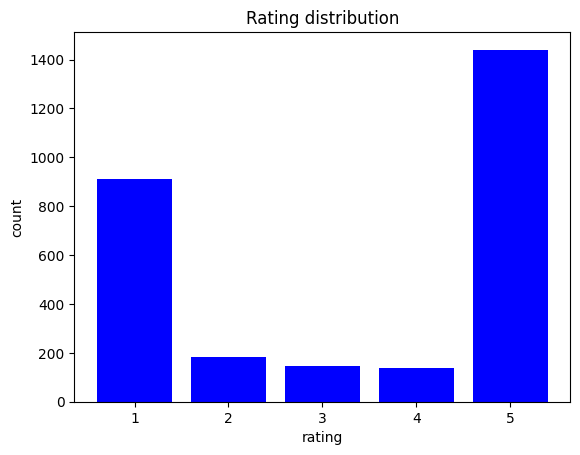

In [38]:
# Plot the distribution
review_counts = reviews.groupby(['rating'])['rating'].agg(['count'])
fig, ax = plt.subplots()
x = review_counts.index
y = review_counts['count']

plt.bar(x, y, color = "blue")
plt.xlabel('rating')
plt.ylabel('count')
plt.title('Rating distribution')
plt.show()

### Resampling

Resampling is done to keep the data balanced. Downsampling will be used.

In [39]:
# Take samples from each category that's larger than the smallest category
samp_size = len(reviews[reviews['rating'] == 4])
random_state = 3
t_1 = reviews[reviews['rating'] == 1].sample(n=samp_size, random_state=random_state)
t_2 = reviews[reviews['rating'] == 2].sample(n=samp_size, random_state=random_state)
t_3 = reviews[reviews['rating'] == 3].sample(n=samp_size, random_state=random_state)
t_4 = reviews[reviews['rating'] == 4]
t_5 = reviews[reviews['rating'] == 5].sample(n=samp_size, random_state=random_state)

reviews_resampled = pd.concat([t_1, t_2, t_3, t_4, t_5])
reviews_resampled.reset_index(inplace = True)

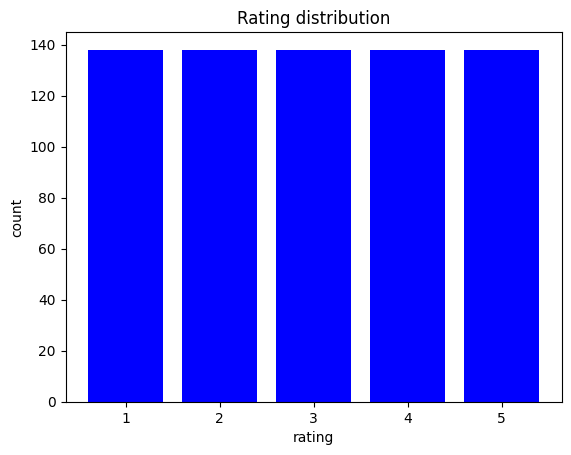

In [40]:
# Re-plot the distribution
review_counts_resampled = reviews_resampled.groupby(['rating'])['rating'].agg(['count'])
fig, ax = plt.subplots()
x = review_counts_resampled.index
y = review_counts_resampled['count']

plt.bar(x, y, color = "blue")
plt.xlabel('rating')
plt.ylabel('count')
plt.title('Rating distribution')
plt.show()

We now have an equal representation from each class

### Set up X and y

In [41]:
X = reviews_resampled['review_tokens']
y = reviews_resampled['rating']
X

0      the night before my daughter s birthday dinner...
1      breakfast disaster twice we went first tears i...
2      i enjoy restaurants i enjoy going out and ever...
3      no one will see because yelp only shows their ...
4      we were helping some friends move we were movi...
                             ...                        
685    i love my yelp events and the community manage...
686    this store is not expensive this is the highes...
687    finished the region gymnastics championships i...
688    just wow let me start off with this place make...
689    my sister i enjoyed lunch by sharing the dinne...
Name: review_tokens, Length: 690, dtype: string

In [42]:
type(X[0])

str

In [43]:
y

0      1
1      1
2      1
3      1
4      1
      ..
685    5
686    5
687    5
688    5
689    5
Name: rating, Length: 690, dtype: int64

### Feature Extraction

Count vectorizer

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the vectorizer
cvec = CountVectorizer()

# Fit and transform the training data to a sparse matrix
cvec.fit(X)
X_cvec = cvec.transform(X)

### Train-Test Split

In [45]:
X_cvec

<690x7069 sparse matrix of type '<class 'numpy.int64'>'
	with 57808 stored elements in Compressed Sparse Row format>

In [46]:
X_cvec.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [47]:
X_cvec_df = pd.DataFrame(X_cvec.toarray(), columns = cvec.get_feature_names_out())
X_cvec_df.head(5)

,aa,aaa,aback,abc,abdominal,abe,ability,abington,able,abomination,...,yum,yuma,zagat,zain,zero,zipper,zippo,zoo,zoom,zuckers
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_cvec_df, y, test_size = 0.3, random_state = 1)

print(f'Original DataFrame: \nX_cvec_df: {X_cvec_df.shape}\n')

print('Train and test sizes:')
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

Original DataFrame: 
X_cvec_df: (690, 7069)

Train and test sizes:
X_train: (483, 7069)
X_test: (207, 7069)
y_train: (483,)
y_test: (207,)


### Train and Evaluate An Initial Random Forest Model

In [49]:
# Initialize a random forest model
rf_mdl = RandomForestClassifier(random_state = 1)

# Fit the model (solve the for the weights)
rf_mdl.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_mdl.predict(X_test)

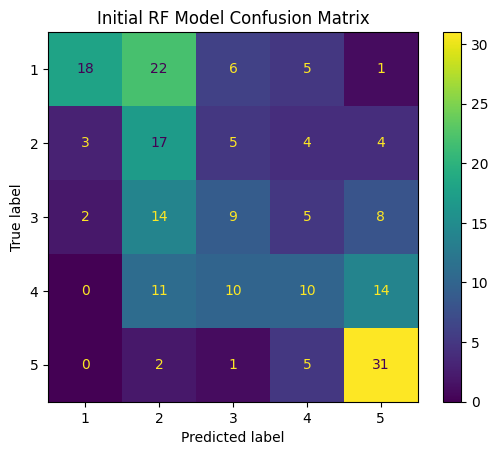

In [50]:
# Create a confusion matrix
conf_mat = confusion_matrix(y_test, y_pred, labels = rf_mdl.classes_)

# Create a confusion matrix visualization
disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = rf_mdl.classes_)
disp.plot()
plt.title('Initial RF Model Confusion Matrix')
plt.show()

Classification report

In [51]:
print(classification_report(y_test, y_pred, labels = rf_mdl.classes_))

              precision    recall  f1-score   support

           1       0.78      0.35      0.48        52
           2       0.26      0.52      0.34        33
           3       0.29      0.24      0.26        38
           4       0.34      0.22      0.27        45
           5       0.53      0.79      0.64        39

    accuracy                           0.41       207
   macro avg       0.44      0.42      0.40       207
weighted avg       0.47      0.41      0.40       207



Overall, this model's performance is poor, because it's accuracy is 41 percent. Delving deeper, we see that for classes 2, 3, 4, and 5, the model's predictions are all over the place. The capture of true positives is also poor across classes 1, 2, 3, and 4. On the positive side, predictions for class 1 were mostly correct, and the capture for class 5 was mostly correct. However, taking performance overall, the model did not do well. Thus, more features should be engineered to capture more meaning, and possibly a re-distribution of the labels.

## Re build the model but just use title tokens instead

Let's see if the model's metrics improve by using tokens only from the title instead

### Set up X and y

We will use X2 and y2 for this to keep things separate

In [52]:
X2 = reviews_resampled['title_tokens']
y2 = reviews_resampled['rating']
X2

0                                  cancelled reservation
1                         bonefish grill williamsburg va
2                      look for reviews elsewhere people
3                                   no one will see this
4                    good tears in my eyes moving do not
                             ...                        
685                                       foodies unites
686    do not believe the expensive fake reviews laug...
687                                   gymnastics special
688                                       love love love
689                                       delicious food
Name: title_tokens, Length: 690, dtype: string

### Feature Extraction

Check for NaNs in the titles

In [53]:
X2[X2.isna()]

60     <NA>
95     <NA>
129    <NA>
136    <NA>
150    <NA>
241    <NA>
454    <NA>
Name: title_tokens, dtype: string

Since there are only 7 NaNs in the dataset and there isn't anything that you can replace them with, it would be best to drop them from the dataset here.

In [54]:
# Store the NaNs so that they can be dropped from both X and Y
NaN_indices = X2[X2.isna()].index

# Drop them from X and Y
X2 = X2.drop(NaN_indices)
y2 = y2.drop(NaN_indices)

Count Vectorizer

In [55]:
# Initialize the vectorizer
cvec2 = CountVectorizer()

# Fit and transform the training data to a sparse matrix
cvec2.fit(X2)
X_cvec2 = cvec2.transform(X2)

In [56]:
X2_cvec_df = pd.DataFrame(X_cvec2.toarray(), columns = cvec2.get_feature_names_out())
X2_cvec_df.head(5)

,abigails,about,absolute,absolutely,accessible,account,across,activist,actually,acute,...,yelping,yelpuser,yes,yet,you,your,yum,yuma,zero,zin
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Modeling with title tokens

In [57]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_cvec_df, y2, test_size = 0.3, random_state = 1)

print(f'Original DataFrame: \nX_cvec_df: {X2_cvec_df.shape}\n')

print('Train and test sizes:')
print(f'X_train: {X2_train.shape}')
print(f'X_test: {X2_test.shape}')
print(f'y_train: {y2_train.shape}')
print(f'y_test: {y2_test.shape}')

Original DataFrame: 
X_cvec_df: (683, 1229)

Train and test sizes:
X_train: (478, 1229)
X_test: (205, 1229)
y_train: (478,)
y_test: (205,)


In [58]:
rf_mdl2 = RandomForestClassifier(random_state = 1)

# Fit the model
rf_mdl2.fit(X2_train, y2_train)

# Make predictions on the test data
y2_pred = rf_mdl2.predict(X2_test)

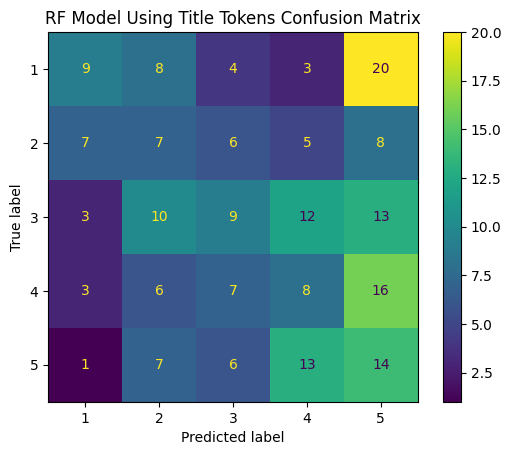

In [59]:
# Create a confusion matrix
conf_mat2 = confusion_matrix(y2_test, y2_pred, labels = rf_mdl2.classes_)

# Create a confusion matrix visualization
disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat2, display_labels = rf_mdl2.classes_)
disp.plot()
plt.title('RF Model Using Title Tokens Confusion Matrix')
plt.show()

In [60]:
print(classification_report(y2_test, y2_pred, labels = rf_mdl.classes_))

              precision    recall  f1-score   support

           1       0.39      0.20      0.27        44
           2       0.18      0.21      0.20        33
           3       0.28      0.19      0.23        47
           4       0.20      0.20      0.20        40
           5       0.20      0.34      0.25        41

    accuracy                           0.23       205
   macro avg       0.25      0.23      0.23       205
weighted avg       0.26      0.23      0.23       205



Turns out that this model is worse than the previous one, despite my initial assumption!

## Try using Tf-Idf instead to see if that will work

Set up the DataFrame

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a tvec object and transform X
tvec = TfidfVectorizer()
tvec.fit(X)
X_tvec = tvec.transform(X)

In [62]:
#Create a dataframe that includes X_tvec
X_tvec_df = pd.DataFrame(X_tvec.toarray(), columns = tvec.get_feature_names_out())
X_tvec_df.head(5)

,aa,aaa,aback,abc,abdominal,abe,ability,abington,able,abomination,...,yum,yuma,zagat,zain,zero,zipper,zippo,zoo,zoom,zuckers
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model Creation and Evaluation

In [63]:
# Train test split
X_train_tvec, X_test_tvec, y_train, y_test = train_test_split(X_tvec_df, y, test_size = 0.3, random_state = 1)

# Train the model
rf_mdl_tvec = RandomForestClassifier(random_state = 1)
rf_mdl_tvec.fit(X_train_tvec, y_train)

# Make predictions
y_pred = rf_mdl_tvec.predict(X_test_tvec)

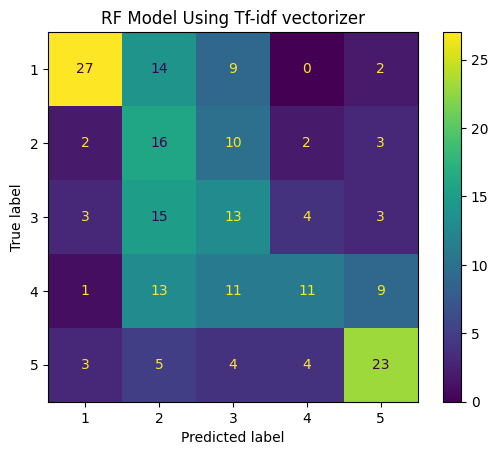

In [64]:
# Create a confusion matrix
conf_mat_tvec = confusion_matrix(y_test, y_pred, labels = rf_mdl_tvec.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat_tvec, display_labels = rf_mdl_tvec.classes_)
disp.plot()
plt.title("RF Model Using Tf-idf vectorizer")
plt.show()

In [65]:
# Create a classifcation report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.75      0.52      0.61        52
           2       0.25      0.48      0.33        33
           3       0.28      0.34      0.31        38
           4       0.52      0.24      0.33        45
           5       0.57      0.59      0.58        39

    accuracy                           0.43       207
   macro avg       0.48      0.44      0.43       207
weighted avg       0.50      0.43      0.45       207



This model had a slightly better accuracy than the initial random forest model using the count vectorizer. The main difference spotted here is that this model had a much better recall for negative reviews and a better precision for the positive reviews. Additionally,
- Lots of neutral to negative reviews were predicted as "2", including some of class 4
- Classes 3 and 4 were predicted quite poorly - very little recall for these classes and not much better precision

There could be some benefit from grouping similar classes together but that would not fix class 4 being incorrectly predicted as neutral to negative. Some better feature extraction is needed

## Tune n-grams

n_grams represents how many words are included in a token. The models so far have used one word per token. Let's compare accuracies between models that are built with different n_grams (two, three, four, ...n words per token)

In [70]:
def count_vec_ngrams(params, X, y):
    cvec = CountVectorizer(ngram_range = (params))
    cvec.fit(X)
    X_cvec = cvec.transform(X)
    X_cvec_df = pd.DataFrame(X_cvec.toarray(), columns = cvec.get_feature_names_out())
    X_train, X_test, y_train, y_test = train_test_split(X_cvec_df, y, test_size = 0.3, random_state = 1)
    rf_mdl = RandomForestClassifier(random_state = 1)
    rf_mdl.fit(X_train, y_train)
    y_pred = rf_mdl.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

params = [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
ngram_scores = [count_vec_ngrams(p, X, y) for p in params]
ngrams = ['cvec ngram_1', 'cvec ngram_2', 'cvec ngram_3', 'cvec ngram_4', 'cvec ngram_5']
ngram_score_df = pd.DataFrame({'params': ngrams, 'accuracy': ngram_scores})

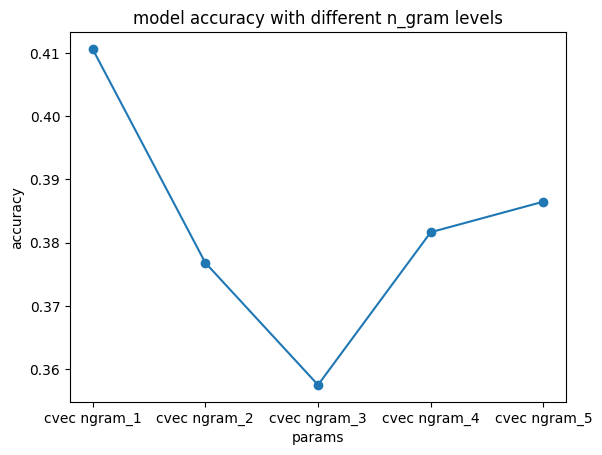

In [71]:
fig = plt.subplots()
plt.plot(ngram_score_df['params'], ngram_score_df['accuracy'])
plt.scatter(ngram_score_df['params'], ngram_score_df['accuracy'])
plt.xlabel('params')
plt.ylabel('accuracy')
plt.title('model accuracy with different n_gram levels')
plt.show()